In [25]:
import numpy as np
import pandas as pd
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from scipy import ndimage
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
from keras import backend as K
from keras.layers import Lambda

In [2]:
#!pip install tensorflow_addons

In [3]:
#import tensorflow_addons as tfa

In [4]:
os.listdir('../input/abstraction-and-reasoning-challenge')

['test', 'evaluation', 'sample_submission.csv', 'training']

In [5]:
from pathlib import Path

data_path = Path('/kaggle/input/abstraction-and-reasoning-challenge/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'

In [6]:
l = os.listdir(training_path)

In [7]:
task_file = str(training_path / l[1])

with open(task_file, 'r') as f:
    task = json.load(f)

print(task.keys())

dict_keys(['train', 'test'])


In [8]:
#np.array(task['train'][0]['input']).shape
#img = task['train'][0]
#x = img['input']
#x = np.array(x)
#z = np.array([11]*15).reshape(15,1)
#f = np.concatenate((x,z),axis = 1).flatten()
#f = np.insert(f,0,10)
#f[-1] = 12
#np.random.choice(4)
#np.random.choice(5,4,replace = False)

In [9]:
def plot_task(task):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 4, figsize=(15,15))
    axs[0].imshow(task['train'][0]['input'], cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title('Train Input')
    axs[1].imshow(task['train'][0]['output'], cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title('Train Output')
    axs[2].imshow(task['test'][0]['input'], cmap=cmap, norm=norm)
    axs[2].axis('off')
    axs[2].set_title('Test Input')
    axs[3].imshow(task['test'][0]['output'], cmap=cmap, norm=norm)
    axs[3].axis('off')
    axs[3].set_title('Test Output')
    plt.tight_layout()
    plt.show()

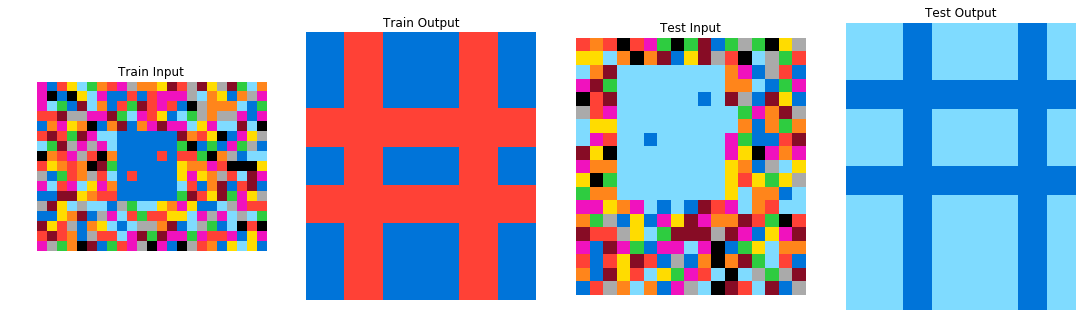

In [11]:
plot_task(task)

In [12]:
def rotate(a,b):
    i = np.random.choice(4)
    i = i*90
    a = ndimage.rotate(a,i)
    b = ndimage.rotate(b,i)
    return(a,b)

In [13]:
#color swap fixes black and gray.

def colour_swap(a,b):
    l = [1,2,3,4,6,7,8,9]
    t = np.random.choice(l,8,replace = False)
    d = {}
    for j in range(8):
        d[l[j]] = t[j]
    d[0] = 0
    d[5] = 5
    x = a.flatten()
    y = b.flatten()
    a1 = np.array([d[z] for z in x])
    b1 = np.array([d[z] for z in y])
    a1 = a1.reshape(a.shape)
    b1 = b1.reshape(b.shape)
    return(a1,b1)

In [14]:
def make_sequence(a,target):
    r,c = a.shape
    z = np.array([11]*r).reshape(r,1)
    f = np.concatenate((a,z),axis = 1).flatten()
    if target:
        f = np.insert(f,0,10)
        f = np.append(f,12)
    return(f)

In [15]:
def make_np(a,b):
    a = np.array(a)
    b = np.array(b)
    return(a,b)

In [16]:
def get_dims(task):
    i = []
    o = []
    for d in task['train']:
        r,c = np.array(d['input']).shape
        i.append((r+1)*c)
        r,c = np.array(d['output']).shape
        o.append((r+1)*c)
    i1 = max(i)
    o1 = max(o)
    return(i1,o1+2)

In [17]:
# colours go from 1 ---> 10, 
# End of lines are denoted by 12
# start of the whole sequence (sos token) is 11
# End of sequence (eos) token is 13

def augment(task,sam_len):
    m = len(task['train'])
    l1 = []
    l2 = []
    in_d,o_d = get_dims(task)
    inputs_e = np.full((sam_len,in_d),-1)
    inputs_d = np.full((sam_len,1),-1)
    targets = np.full((sam_len,o_d),-1)
    for j in range(sam_len):
        i = np.random.choice(m)
        #i = 0
        a = task['train'][i]['input']
        b = task['train'][i]['output']
        a,b = make_np(a,b)
        a,b = rotate(a,b)
        a,b = colour_swap(a,b)
        a = make_sequence(a,False) #target = False
        b = make_sequence(b,True)  #target = True
        inputs_e[j,:len(a)] = a
        inputs_d[j,0] = 10
        targets[j,:len(b)-1] = b[1:]
    return(inputs_e+1,inputs_d+1,targets+1)    

In [18]:
def generate_batch(inputs_e,inputs_d,targets,task,sam_len,batch_size):
  # inputs_e,inputs_d,targets = augment(task,sam_len)
    while True:
          for j in range(0,len(inputs_e),batch_size):
                a = inputs_e[j:j+batch_size]
                b = inputs_d[j:j+batch_size]
                c = targets[j:j+batch_size]
                q = len(c[0])
                t_new = np.zeros((batch_size,q,14))
                for i in range(batch_size):
                    for k in range(q):
                        if c[i,k] > 0:
                            t_new[i,k,c[i,k]] = 1
                        else:
                            t_new[i,k,c[i,k]] = 0
                yield(a,t_new)

In [19]:
#train_samples = len(X_train)
#val_samples = len(X_test)
batch_size = 32
epochs = 10
latent_dim = 256

In [20]:
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(14,latent_dim,mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
states = [state_h, state_c]

In [21]:

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(1,))
dec_emb_layer = Embedding(14,latent_dim, mask_zero = True)
#dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
#decoder_outputs, _, _ = decoder_lstm(dec_emb,initial_state=encoder_states)
decoder_dense = Dense(14, activation='softmax')
#decoder_outputs = decoder_dense(decoder_outputs)

In [22]:
max_decoder_seq_length = 100

In [23]:
all_outputs = []
inputs = decoder_inputs
for _ in range(max_decoder_seq_length):
    x,state_h,state_c = decoder_lstm(inputs,initial_state = states)
    outputs = decoder_dense(x)
    all_outputs.append(outputs)
    inputs = outputs
    states = [state_h,state_c]

ValueError: Input 0 is incompatible with layer lstm_2: expected ndim=3, found ndim=2

In [24]:
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

NameError: name 'Lambda' is not defined

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(optimizer= 'rmsprop', loss= 'categorical_crossentropy', metrics=['acc'])

In [ ]:
batch_size = 32
sam_len = 512
epochs = 15
val_len = 128

In [ ]:
model.summary()

In [ ]:
inputs_e,inputs_d,targets = augment(task,sam_len)
inputs_1e,inputs_1d,targets1 = augment(task,sam_len)
model.fit_generator(generator = generate_batch(inputs_e,inputs_d,targets,task,sam_len,batch_size),
                steps_per_epoch = sam_len//batch_size,
                epochs = epochs,
                validation_data = generate_batch(inputs_1e,inputs_1d,targets1,task,val_len,batch_size),
                validation_steps = val_len//batch_size)

In [ ]:
# Encode the input sequence to get the "Context vectors"
encoder_model = Model(encoder_inputs, encoder_states)
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_input = [decoder_state_input_h, decoder_state_input_c]
# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_input)
decoder_states2 = [state_h2, state_c2]
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)
# Final decoder model
decoder_model = Model([decoder_inputs] + decoder_state_input,[decoder_outputs2] + decoder_states2)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of 
    #target sequence with the start character.
    target_seq[0, 0] = 11
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sequence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Sample a token
        sampled_index= np.argmax(output_tokens[0, -1, :])
        decoded_sequence.append(sampled_index)
        # Exit condition: either hit max length
        # or find stop character.
        if len(decoded_sequence) > 300:
        #(sampled_index == 13 or
            stop_condition = True
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_index
        # Update states
        states_value = [h, c]
    return decoded_sequence

In [ ]:
input_seq = np.array(task['train'][0]['input'])
input_seq = make_sequence(input_seq,False)+1

In [ ]:
out_seq = np.array(task['train'][0]['output'])
out_seq = make_sequence(out_seq,False)+1
out_seq

In [ ]:
decode_sequence(input_seq)

In [ ]:
inputs_e,inputs_d,targets = augment(task,sam_len)
inputs_1e,inputs_1d,targets1 = augment(task,sam_len)
model12.fit_generator(generator = generate_batch(inputs_e,inputs_d,targets,task,sam_len,batch_size),
                steps_per_epoch = sam_len//batch_size,
                epochs = epochs,
                validation_data = generate_batch(inputs_1e,inputs_1d,targets1,task,val_len,batch_size),
                validation_steps = val_len//batch_size)